In [0]:
import os
os.chdir('/content/drive/My Drive/BUSI')

# Import modules

In [0]:
import math
import cv2
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv2D, Dense, Flatten, Activation,
    InputLayer, BatchNormalization, 
    Concatenate, MaxPooling2D, Layer, 
    UpSampling2D, Conv2DTranspose, Input
) 
from tensorflow.keras.models import Model

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint,
    ReduceLROnPlateau
)
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, Iterator
from tensorflow.keras.utils import Sequence

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# STAN Model implementation

### Blocks

In [0]:

class Conv2DBlock(Layer):
    def __init__(self, n_filters, kernel_size, activation='relu', use_bn=False, name='conv2d', **kwargs):
        super(Conv2DBlock, self).__init__()
        self.conv = Conv2D(n_filters, kernel_size, name=f'{name}_conv', use_bias=(not use_bn), padding='same')
        self.use_bn = use_bn
        if use_bn:
            self.bn = BatchNorm(name=f'{name}_bn')
        self.activation = Activation(activation, name=f'{name}_activation')
        
    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.bn(x)
        x = self.activation(x)
        return x


class BatchNorm(BatchNormalization):
    """
    Make trainable=False freeze BN for real (the og version is sad)
    """
    def call(self, x, training=False):
        if training is None:
            training = tf.constant(False)
        training = tf.logical_and(training, self.trainable)
        return super().call(x, training)


class EncoderBlock(Layer):
    def __init__(self, n_filters, name='enc'):
        super(EncoderBlock, self).__init__()
        self.conv3_1 = Conv2DBlock(n_filters=n_filters, kernel_size=3, name=f'{name}_kernel3_1')
        self.conv3_2 = Conv2DBlock(n_filters=n_filters, kernel_size=3, name=f'{name}_kernel3_2')
        self.conv3_pool = MaxPooling2D(pool_size=(2,2), name=f'{name}_kernel3_pool')

        self.conv1_1 = Conv2DBlock(n_filters=n_filters, kernel_size=1, name=f'{name}_kernel1_1')
        self.conv1_2 = Conv2DBlock(n_filters=n_filters, kernel_size=1, name=f'{name}_kernel1_2')

        self.conv5_1 = Conv2DBlock(n_filters=n_filters, kernel_size=5, name=f'{name}_kernel5_1')
        self.conv5_2 = Conv2DBlock(n_filters=n_filters, kernel_size=5, name=f'{name}_kernel5_1')
        self.agg_pool = MaxPooling2D(pool_size=(2,2), name=f'{name}_agg_pool')


    def call(self, kernel3_inp, kernelconcat_inp):
        """Feed forward through the Encoder block

        Arguments:
            kernel3_inp {tensor} -- feature maps of kernel3 conv from previous block or just an image
            kernelconcat_inp {[type]} -- feature maps of concatenation (kernel1 + kernel5) from previous block or just an image

        Returns:
            tuple -- (kernel3 output, concat output, skip connection 1, skip connection 2)
        """        

        x1 = self.conv1_1(kernelconcat_inp)
        x1 = self.conv1_2(x1)

        x5 = self.conv5_1(kernelconcat_inp)
        x5 = self.conv5_2(x5)
        
        concat = tf.concat([x1, x5], axis=3)
        concat_pool = self.agg_pool(concat)

        x3 = x3_1 = self.conv3_1(kernel3_inp)
        x3 = skip1 = self.conv3_2(x3)
        x3_pool = self.conv3_pool(x3)

        skip2 = tf.concat([x3_1, concat], axis=3)
        return x3_pool, concat_pool, skip1, skip2

class DecoderBlock(Layer):
    def __init__(
        self, 
        n_filters, 
        mode='upsampling'):
        """Initialize Decoding Block using UpSample layers

        Arguments:
            n_filters {int} -- number of filters for each conv2d layers

        Keyword Arguments:
            mode {str} -- Decoding mode (default: {'upsampling'})

        Raises:
            ValueError: when the mode is not 'upsampling' or 'transpose'
        """        
    
        super(DecoderBlock, self).__init__()
        # self.conv_1 = Conv2D(n_filters, kernel_size=3, padding='same', activation='relu')
        self.conv_1 = Conv2DBlock(n_filters, kernel_size=3)
        # self.conv_2 = Conv2D(n_filters, kernel_size=3, padding='same')
        self.conv_2 = Conv2DBlock(n_filters, kernel_size=3)

        if mode == 'upsampling':
            self.up = UpSampling2D(size=(2,2))
        elif mode == 'transpose':
            self.up = Conv2DTranspose(n_filters // 2, kernel_size=3, padding='same')
        else:
            raise ValueError()

    def call(self, inp, skip1, skip2):
        """Feed forward the Decoding block

        Arguments:
            inp {tensor} -- the main input
            skip1 {tensor} -- feature maps from skip connection 1
            skip2 {tensor} -- feature maps from skip connection 2

        Returns:
            tensor -- output
        """        
        x = self.up(inp)
        x = self.conv_1(tf.concat([x, skip1], axis=3))
        x = self.conv_2(tf.concat([x, skip2], axis=3))
        return x


### Builder Functions

In [0]:
def build_stan(
    n_classes,
    input_shape=(256, 256, 3),
    filters=[32, 64, 128, 256, 512],
    activation='sigmoid'
):
    """Pure STAN builder using Conv blocks (no backbone)

    Arguments:
        n_classes {int} -- Number of classes

    Keyword Arguments:
        input_shape {tuple} -- The shape of input (default: {(256, 256, 3)})
        filters {list} -- Declare number of filters for each encoding block (default: {[32, 64, 128, 256, 512]})
        activation {str} -- activation function of the last layer before giving prediction
    """
    # inp = InputLayer(input_shape=input_shape)
    inp = Input(shape=input_shape)
    
    # Encoder
    x3_pool, concat_pool, skip1_b1, skip2_b1 = EncoderBlock(filters[0])(
        kernel3_inp=inp, kernelconcat_inp=inp)
    
    x3_pool, concat_pool, skip1_b2, skip2_b2 = EncoderBlock(filters[1])(
        kernel3_inp=x3_pool, kernelconcat_inp=concat_pool)
    
    x3_pool, concat_pool, skip1_b3, skip2_b3 = EncoderBlock(filters[2])(
        kernel3_inp=x3_pool, kernelconcat_inp=concat_pool)
    
    x3_pool, concat_pool, skip1_b4, skip2_b4 = EncoderBlock(filters[3])(
        kernel3_inp=x3_pool, kernelconcat_inp=concat_pool)
    
    # middle
    x3_pool         = Conv2DBlock(n_filters=filters[4], kernel_size=3)(x3_pool)
    x3_pool         = Conv2DBlock(n_filters=filters[4], kernel_size=3)(x3_pool)
    concat_pool_1   = Conv2DBlock(n_filters=filters[4], kernel_size=1)(concat_pool)
    concat_pool_1   = Conv2DBlock(n_filters=filters[4], kernel_size=3)(concat_pool)
    concat_pool_5   = Conv2DBlock(n_filters=filters[4], kernel_size=5)(concat_pool)
    concat_pool_5   = Conv2DBlock(n_filters=filters[4], kernel_size=3)(concat_pool)

    mid = tf.concat([x3_pool, concat_pool_1, concat_pool_5], axis=3, name='middle_fm')
    
    # Decoder
    x = DecoderBlock(n_filters=filters[3])(mid, skip1_b4, skip2_b4)
    x = DecoderBlock(n_filters=filters[2])(x, skip1_b3, skip2_b3)
    x = DecoderBlock(n_filters=filters[1])(x, skip1_b2, skip2_b2)
    x = DecoderBlock(n_filters=filters[0])(x, skip1_b1, skip2_b1)
    
    # Last conv layer
    x = Conv2DBlock(n_filters=n_classes, kernel_size=3, activation=activation)(x)

    return Model(inp, x)

In [0]:
def freeze_model(model):
    for layer in model.layers:
        layer.trainable = True

def STAN(
    n_classes, 
    input_shape=(256, 256, 3),
    encoder_weights=None,
    output_activation='sigmoid',
    freeze_encoder=False,
    model_name='stan'
):
    """[summary]

    Arguments:
        n_classes {[type]} -- [description]

    Keyword Arguments:
        input_shape {tuple} -- [description] (default: {(256, 256, 3)})
        encoder_weights {[type]} -- [description] (default: {None})
        output_activation {str} -- [description] (default: {'sigmoid'})
        freeze_encoder {bool} -- [description] (default: {False})
    """    
    model = build_stan(n_classes=n_classes, input_shape=input_shape, activation=output_activation)
    
    if freeze_encoder:
        freeze_model(model)
    
    # model.name = model_name

    return model

# Training on BUSI dataset

#### Loss functions

In [0]:

def _lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


def _flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels


def _lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = _flatten_binary_scores(log, lab, ignore)
            return _lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = _lovasz_hinge_flat(*_flatten_binary_scores(logits, labels, ignore))
    return loss


def _lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = _lovasz_grad(gt_sorted)
        loss = tf.tensordot(
            tf.nn.relu(errors_sorted),
            tf.stop_gradient(grad),
            1,
            name="loss_non_void"
        )
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def lovasz_loss(y_true, y_pred):
    y_true = K.cast(K.squeeze(y_true, -1), 'int32')
    y_pred = K.cast(K.squeeze(y_pred, -1), 'float32')
    # logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred  # Jiaxin
    loss = _lovasz_hinge(logits, y_true, per_image=True, ignore=None)
    return loss


def combination_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) + 0.5 * lovasz_loss(y_true, y_pred)

def dice_cost(y_true, y_predicted):

    return -dice_coef(y_true, y_predicted)

#### Metrics

In [0]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.cast(y_pred > t, tf.int32)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

#### Callbacks

In [0]:
callbacks = [
    ModelCheckpoint('model.h5', monitor='val_loss', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=5),
    ReduceLROnPlateau(monitor='val_loss', patience=3)
]

#### Generator


In [0]:
class BaseGenerator(Iterator):
    def __init__(
        self,
        fnames,
        data_dir='.',
        n_classes=1,
        resized_shape=(256, 256),
        batch_size=8,
        shuffle=False,
        seed=None,
        **kwargs
    ):
        """Generator initialization, inherits Iterator class

        Arguments:
            fnames {list} -- List of filenames from dataset (not including extension part)

        Keyword Arguments:
            data_dir {str} -- The main dataset directory (default: {'.'})
            n_classes {int} -- Number of classes (default: {1})
            resized_shape {tuple} -- All images are reshaped to this size (default: {(256, 256)})
            batch_size {int} -- Batch size (default: {8})
            shuffle {bool} -- (default: {False})
        """    
        self.fnames = fnames
        self.data_dir = data_dir
        self.seed = seed
        self.ids = np.array(range(len(fnames)))
        self.n_samples = len(self.ids)
        self.resized_shape = resized_shape
        
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.cursor = 0

        self.img_gen = ImageDataGenerator(**kwargs)
        self.msk_gen = ImageDataGenerator(**kwargs)

    def __len__(self):
        return math.ceil(self.n_samples / self.batch_size)
    
    def on_epoch_end(self):
        self.cursor = 0
        if self.shuffle:
            np.random.shuffle(self.ids)

    def __getitem__(self, idx):
        indices = self.ids[idx * self.batch_size:(idx + 1) * self.batch_size]
        # for i in range(self.batch_size):
        #     indices.append(self.ids[self.cursor])
        #     if self.cursor == self.n_samples - 1:
        #         self.cursor = 0
        #     else:
        #         self.cursor += 1
        imgs, msks = self._read_data(indices)
        imgs, msks = self._preprocessing(imgs, msks)
        return imgs, msks

    def _preprocessing(self, imgs, msks=None):
        # imgs[..., 0] -= 103.939
        # imgs[..., 1] -= 116.779
        # imgs[..., 2] -= 123.68
        imgs /= 255
        # imgs -= 1.
        imgs = self.img_gen.random_transform(x=imgs, seed=self.seed)
        if msks is not None:
            msks /= 255
            msks = self.msk_gen.random_transform(x=msks, seed=self.seed)
            return imgs, msks
        return imgs

    def _read_data(self, ids):
        raise NotImplementedError

class BUSIGenerator(BaseGenerator):
    def __init__(self, fnames, input_channel=3, **kwargs):
        super(BUSIGenerator, self).__init__(fnames, **kwargs)
        self.input_channel = input_channel

    def _read_data(self, ids):
        imgs = np.empty((self.batch_size, self.resized_shape[0],
                        self.resized_shape[1], self.input_channel))
        msks = np.empty((self.batch_size, self.resized_shape[0], self.resized_shape[1], 1))

        for i, index in enumerate(ids):
            file_name = self.fnames[index]
            # img = Image.open(os.path.join(self.data_dir, 'images', f'{self.fnames[index]}.png'))
            # msk = Image.open(os.path.join(self.data_dir, 'masks', f'{self.fnames[index]}.png'))
            
            # if self.resized_shape:
            #     img = img.resize(self.resized_shape, Image.NEAREST)
            #     if self.input_channel == 1:
            #         img = img.convert('L')
            #     else:
            #         img = img.convert('RGB')
            #     msk = msk.resize(self.resized_shape, Image.NEAREST).convert('L')
            
            # print(f'{self.fnames[index]}.png')
            # imgs[i] = np.array(img)
            # msks[i] = np.expand_dims(np.array(msk, dtype=np.int32), axis=2)
            read_im_mode = 1
            if self.input_channel == 1:
                read_im_mode = 0
            img = cv2.imread(os.path.join(self.data_dir, 'images', f'{file_name}.png'), read_im_mode)
            msk = cv2.imread(os.path.join(self.data_dir, 'masks', f'{file_name}.png'), 0)

            if self.resized_shape:
                img = cv2.resize(img, self.resized_shape)
                msk = cv2.resize(msk, self.resized_shape)

            imgs[i] = img
            msks[i] = np.expand_dims(msk, axis=2)
        
        return imgs, msks

In [0]:
BATCH_SIZE = 8
input_shape = (256, 256, 3)

In [0]:
fnames = [os.path.splitext(f)[0] for f in os.listdir('./images')]

In [0]:
from sklearn.model_selection import train_test_split
im_train, im_val, ms_train, ms_val = train_test_split(fnames, fnames, test_size=0.15, random_state=10)
im_train, im_test, ms_train, ms_test = train_test_split(im_train, ms_train, test_size=0.3, random_state=10)

In [13]:
print(len(im_train))
print(len(im_val))
print(len(im_test))

560
142
241


In [0]:
train_gen = BUSIGenerator(im_train, batch_size=BATCH_SIZE, input_channel=input_shape[-1],
                          resized_shape=(input_shape[0], input_shape[1]), 
                          horizontal_flip=True, seed=10)
val_gen = BUSIGenerator(im_val, batch_size=BATCH_SIZE, 
                        resized_shape=(input_shape[0], input_shape[1]), 
                        horizontal_flip=True, seed=10)
# rotation_range=20, width_shift_range=10,

In [0]:
im, msk =  train_gen[1]

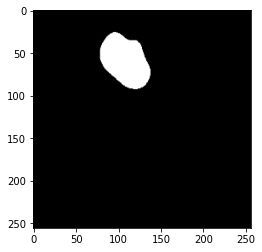

In [16]:
plt.imshow(msk[2][:,:,0], cmap='gray')

In [17]:
msk.max()

1.0

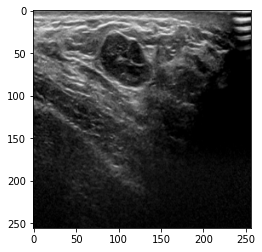

In [18]:
plt.imshow(im[2])

In [19]:
im.max()

1.0

#### Training

In [20]:
!nvidia-smi

Mon May 11 04:02:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
model = STAN(1, input_shape=input_shape)

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='bce', metrics=[dice_coef])

In [0]:
model.fit(x=train_gen, epochs=10, batch_size=BATCH_SIZE, steps_per_epoch=len(train_gen), validation_data=val_gen, validation_steps=1)

Epoch 1/10
62/70 [=========================>....] - ETA: 24s - loss: 0.3529 - dice_coef: 0.0948